# <a title="Activity Recognition" href="https://github.com/hisroar/NNonHexiwear/tree/master/HAR_TF_Example" > DNNs for Human Activity Recognition</a>

Based off of <a href="https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition" > DNNs for Human Activity Recognition</a>.

Human Activity Recognition (HAR) using smartphones dataset and an LSTM RNN. Classifying the type of movement amongst six categories:
- WALKING,
- WALKING_UPSTAIRS,
- WALKING_DOWNSTAIRS,
- SITTING,
- STANDING,
- LAYING.

Data can be fed directly into the neural network who acts like a black box, modeling the problem correctly. [Other research](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names) on the activity recognition dataset can use a big amount of feature engineering, which is rather a signal processing approach combined with classical data science techniques. The approach here is rather very simple in terms of how much was the data preprocessed. 

Let's use Google's neat Deep Learning library, TensorFlow, demonstrating the usage of a DNN, a type of Artificial Neural Network that can process sequential data / time series. 

## Video dataset overview

Follow this link to see a video of the 6 activities recorded in the experiment with one of the participants:

<p align="center">
  <a href="http://www.youtube.com/watch?feature=player_embedded&v=XOEN9W05_4A
" target="_blank"><img src="http://img.youtube.com/vi/XOEN9W05_4A/0.jpg" 
alt="Video of the experiment" width="400" height="300" border="10" /></a>
  <a href="https://youtu.be/XOEN9W05_4A"><center>[Watch video]</center></a>
</p>


In [1]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics

from tensorflow.python.framework.graph_util import remove_training_nodes
from tensorflow.python.framework import graph_util as gu

import os

In [2]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
#     "total_acc_x_",
#     "total_acc_y_",
#     "total_acc_z_"
]
n_input = len(INPUT_SIGNAL_TYPES)

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 


## Let's start by downloading the data: 

In [3]:
# Note: Linux bash commands start with a "!" inside those "ipython notebook" cells

DATA_PATH = "data/"

#!pwd && ls
os.chdir(DATA_PATH)
#!pwd && ls

!python download_dataset.py

#!pwd && ls
os.chdir("..")
#!pwd && ls

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)



Downloading...
Dataset already downloaded. Did not download twice.

Extracting...
Dataset already extracted. Did not extract twice.


Dataset is now located at: data/UCI HAR Dataset/


## Preparing dataset:

In [4]:
TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

# flatten the data to use in DNN
X_train = np.reshape(X_train, [-1, 128 * n_input])
X_test = np.reshape(X_test, [-1, 128 * n_input])

# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


## Additional Parameters:

Here are some core parameter definitions for the training. 

For example, the whole neural network's structure could be summarised by enumerating those parameters and the fact that two LSTM are used one on top of another (stacked) output-to-input as hidden layers through time steps. 

In [5]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = 128#len(X_train[0])  # 128 timesteps per series


# DNN's internal structure

n_classes = 6 # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = 48000000 # Loop a lot
batch_size = 1500
display_iter = 1000000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")


Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 768) (2947, 1) -0.0016706971 0.25597742
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


## Utility functions for training:

In [6]:
# NOTE: The following code was left in because I got it to work with the modified dataset. However, uTensor
#       doesn't support LSTM/RNN, nor does it support reshaping as of March 2019.

#def LSTM_RNN(_X, _weights, _biases):
#     # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
#     # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
#     # Note, some code of this notebook is inspired from an slightly different 
#     # RNN architecture used on another dataset, some of the credits goes to 
#     # "aymericdamien" under the MIT license.

#     # (NOTE: This step could be greatly optimised by shaping the dataset once
#     # input shape: (batch_size, n_steps, n_input)
#     _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
#     # Reshape to prepare input to hidden activation
#     _X = tf.reshape(_X, [-1, n_input]) 
#     # new shape: (n_steps*batch_size, n_input)
    
#     # ReLU activation, thanks to Yu Zhao for adding this improvement here:
#     _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
#     # Split data because rnn cell needs a list of inputs for the RNN inner loop
#     _X = tf.split(_X, n_steps, 0) 
#     # new shape: n_steps * (batch_size, n_hidden)

#     # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
#     lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
#     lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
#     lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
#     # Get LSTM cell output
#     outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

#     # Get last time step's output feature for a "many-to-one" style classifier, 
#     # as in the image describing RNNs at the top of this page
#     lstm_last_output = outputs[-1]
    
#     # Linear activation
#     logits = tf.matmul(lstm_last_output, _weights['out']) + _biases['out']
#     y_pred = tf.argmax(logits, 1, name="y_pred")
    
#     return logits, y_pred

# helper functions for defining NN variables
def weight_variable(shape, name):
    # weight_variable generates a weight variable of a given shape.
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name)

def bias_variable(shape, name):
    # bias_variable generates a bias variable of a given shape.
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name)

# Fully connected NN
# This can be simplified to 2 layers to save space
def DEEP_NN(x):
    # flattened input to 500 neurons
    W_fc1 = weight_variable([n_steps * n_input, 500], name='W_fc1')
    b_fc1 = bias_variable([500], name='b_fc1')
    a_fc1 = tf.add(tf.matmul(x, W_fc1), b_fc1, name="zscore")
    h_fc1 = tf.nn.relu(a_fc1)
    layer1 = tf.nn.dropout(h_fc1, 0.30)

    # 500 input to 300 output
    W_fc2 = weight_variable([500, 300], name='W_fc2')
    b_fc2 = bias_variable([300], name='b_fc2')
    a_fc2 = tf.add(tf.matmul(layer1, W_fc2), b_fc2, name="zscore")
    h_fc2 = tf.nn.relu(a_fc2)
    layer2 = tf.nn.dropout(h_fc2, 0.30)
    
    # 300 input to 300 output
    W_fc3 = weight_variable([300, 300], name='W_fc3')
    b_fc3 = bias_variable([300], name='b_fc3')
    a_fc3 = tf.add(tf.matmul(layer2, W_fc3), b_fc3, name="zscore")
    h_fc3 = tf.nn.relu(a_fc3)
    layer3 = tf.nn.dropout(h_fc3, 0.50)
    
    # 300 input to 50 output
    W_fc4 = weight_variable([300, 50], name='W_fc4')
    b_fc4 = bias_variable([50], name='b_fc4')
    a_fc4 = tf.add(tf.matmul(layer3, W_fc4), b_fc4, name="zscore")
    h_fc4 = tf.nn.relu(a_fc4)
    layer4 = tf.nn.dropout(h_fc4, 0.50)

    # 50 input to n_classes output
    W_fc5 = weight_variable([50, n_classes], name='W_fc5')
    b_fc5 = bias_variable([n_classes], name='b_fc5')
    logits = tf.add(tf.matmul(layer4, W_fc5), b_fc5, name="logits")
    y_pred = tf.argmax(logits, 1, name='y_pred')

    return y_pred, logits

def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_, n_classes=n_classes):
    # Function to encode neural one-hot output labels from number indexes 
    # e.g.: 
    # one_hot(y_=[[5], [0], [3]], n_classes=6):
    #     return [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


## Define neural network

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps * n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Uncomment LSTM code and this code to get LSTM running
# pred, y_pred = LSTM_RNN(x, weights, biases)
y_pred, logits = DEEP_NN(x)

with tf.name_scope("Loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,
                                                               logits=logits)
    cost = tf.reduce_mean(cross_entropy, name="cross_entropy_loss")
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost, name="train_step")

with tf.name_scope("Prediction"):
    correct_pred = tf.equal(y_pred, tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name="accuracy")


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Hooray, now train the neural network:

In [8]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)
saver = tf.train.Saver()

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [logits, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))


Training iter #1500:   Batch Loss = 4.597623, Accuracy = 0.164000004529953
PERFORMANCE ON TEST SET: Batch Loss = 4.2319512367248535, Accuracy = 0.16389548778533936
Training iter #3000000:   Batch Loss = 1.181063, Accuracy = 0.3466666638851166
PERFORMANCE ON TEST SET: Batch Loss = 1.2014389038085938, Accuracy = 0.35629454255104065
Training iter #6000000:   Batch Loss = 1.090551, Accuracy = 0.390666663646698
PERFORMANCE ON TEST SET: Batch Loss = 1.1426442861557007, Accuracy = 0.3864947259426117
Training iter #9000000:   Batch Loss = 0.878868, Accuracy = 0.5406666398048401
PERFORMANCE ON TEST SET: Batch Loss = 1.0072574615478516, Accuracy = 0.5005089640617371
Training iter #12000000:   Batch Loss = 0.692645, Accuracy = 0.637333333492279
PERFORMANCE ON TEST SET: Batch Loss = 0.997093677520752, Accuracy = 0.5673566460609436
Training iter #15000000:   Batch Loss = 0.578733, Accuracy = 0.6893333196640015
PERFORMANCE ON TEST SET: Batch Loss = 0.9528402090072632, Accuracy = 0.6019681096076965
T

## Training is good, but having visual insight is even better:

Okay, let's plot this simply in the notebook for now.

C:\Anaconda3\envs\tf_gpu2\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


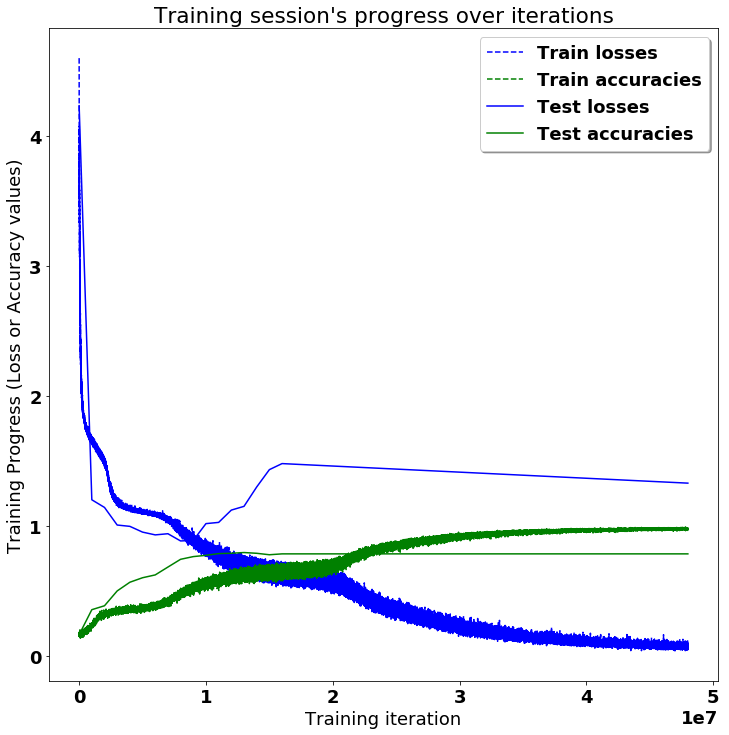

In [9]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

## And finally, the multi-class confusion matrix and metrics!

Testing Accuracy: 78.55446338653564%

Precision: 79.70385591248184%
Recall: 78.55446216491347%
f1_score: 78.73971766818974%

Confusion Matrix:
[[441   7  44   0   2   2]
 [ 18 428  23   0   2   0]
 [ 11  16 392   0   0   1]
 [  2   3   0 338 105  43]
 [  8   4   0 122 375  23]
 [  0   1   0 148  47 341]]

Confusion matrix (normalised to % of total test data):
[[14.964371    0.2375297   1.4930438   0.          0.06786563  0.06786563]
 [ 0.6107906  14.523244    0.7804547   0.          0.06786563  0.        ]
 [ 0.37326095  0.542925   13.301663    0.          0.          0.03393281]
 [ 0.06786563  0.10179844  0.         11.469291    3.5629456   1.459111  ]
 [ 0.2714625   0.13573125  0.          4.1398034  12.724805    0.7804547 ]
 [ 0.          0.03393281  0.          5.0220566   1.5948422  11.571089  ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


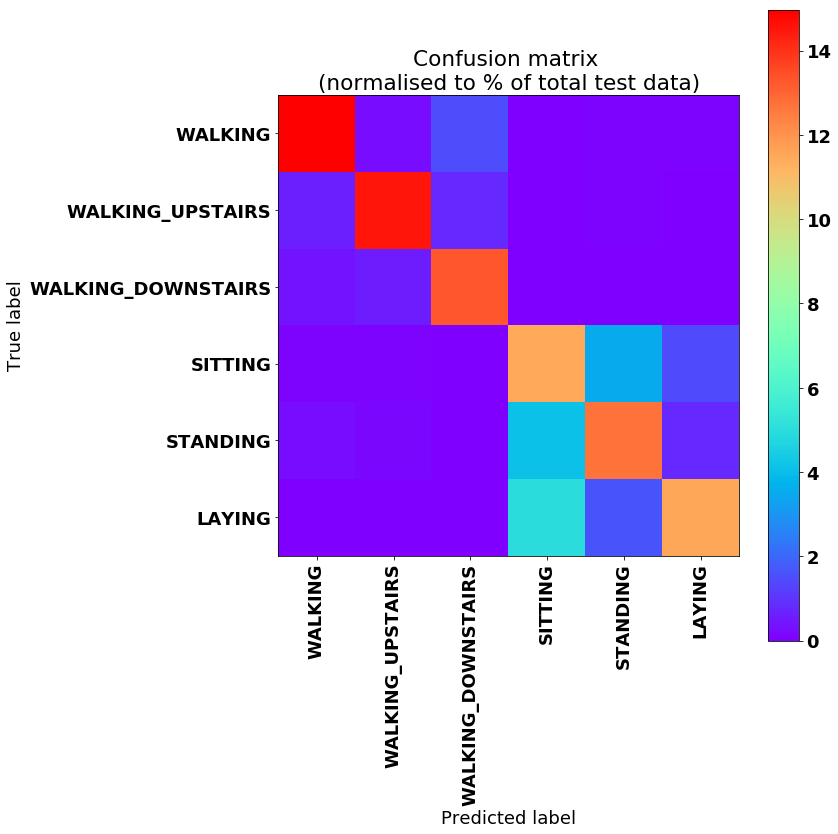

In [10]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Save the DNN as a .pb file

In [11]:
# Freeze the graph
saver.save(sess, "./chkps/lstm_model")
out_nodes = [y_pred.op.name]
print(out_nodes)

# Remove unnecessary training nodes
sub_graph_def = remove_training_nodes(sess.graph_def)

# Freeze constants
sub_graph_def = gu.convert_variables_to_constants(sess, sub_graph_def, out_nodes)

# Save graph to PB file

graph_path = tf.train.write_graph(sub_graph_def,
                                  "./output",
                                  "dnn.pb",
                                  as_text=False)

print('written graph to: %s' % graph_path)

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'W_fc1' has type <class 'str'>, but expected one of: ((<class 'bool'>, <class 'numbers.Integral'>),)
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'W_fc1' has type <class 'str'>, but expected one of: ((<class 'bool'>, <class 'numbers.Integral'>),)
['y_pred']
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.
written graph to: ./output\dnn.pb


In [12]:
sess.close()

## References

The [dataset](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) can be found on the UCI Machine Learning Repository: 

> Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.
